In [1]:
import hail as hl
hl.init(min_block_size=256)
import os
import pandas as pd
import subprocess
os.environ['PYSPARK_SUBMIT_ARGS'] = "--driver-memory 700G pyspark-shell"
# !module load java/java-1.8
gs = "/gstock/biolo_datasets/variation/gnomAD/r2.1.1/vcf/exomes/gnomad.exomes.r2.1.1.sites.ht/"
# gs = "/data/scratch/gnomAD/v3/gnomad.genomes.v3.1.sites.ht/"
data = hl.read_table(gs)
data

Running on Apache Spark version 2.4.1
SparkUI available at http://vega.local:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.64-1ef70187dc78
LOGGING: writing to /enadisk/maison/sage2016/weber/PycharmProjects/EXOTIC/notebooks/Hail/hail-20210423-0840-0.2.64-1ef70187dc78.log


In [2]:
exotic = pd.read_parquet("/gstock/EXOTIC/data/EXOTIC/EXOTIC_modified_zscore_mean_prop_corrected_with_variable.parquet")
biomart = pd.read_csv('/gstock/EXOTIC/data/OTHERS/biomart_refseq_ensembl_hgnc.txt.gz', compression='gzip', sep='\t')
exotic = pd.merge(biomart[['Gene name', 'Chromosome/scaffold name']].drop_duplicates().rename({'Gene name' : 'Gene', 'Chromosome/scaffold name' : 'CHROM'}, axis=1), exotic, on=['Gene'])
exotic['CHROM'] = exotic['CHROM'].astype(str)

exotic = exotic.loc[~exotic['CHROM'].str.contains('HSCHR|HG')]
exotic = exotic[['CHROM', 'CDS_start', 'CDS_stop', 'MAP']].sort_values(by=['CHROM', 'CDS_start'])
exotic.to_csv('/biolo/ngs/remap/EXOTIC.bed', header=False, sep='\t', index=False)

/home/weber/.conda/envs/hail/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
bed_file = hl.import_bed('/biolo/ngs/remap/EXOTIC.bed', reference_genome='GRCh37')
bed_file.count()
# bed_file = bed_file.head(100)
# bed_file.show()

2021-04-23 08:40:38 Hail: INFO: Reading table without type imputation
  Loading field 'f0' as type str (user-supplied)
  Loading field 'f1' as type int32 (user-supplied)
  Loading field 'f2' as type int32 (user-supplied)
  Loading field 'f3' as type str (user-supplied)


29309

In [11]:
data_lite = data.filter(hl.is_defined(bed_file[data.locus]))
data_lite = data_lite.filter(data_lite.variant_type == 'snv')
data_lite = data_lite.filter(data_lite.freq[0]['AC'] > 0)
# data_lite['AF'] = data_lite.freq[0]['AC']
data_lite = data_lite.annotate(
    MAP = bed_file[data_lite.locus].target,
    AF = data_lite.freq[0]['AF'],
    id = hl.str(data_lite.vep.id).replace('/', '_')
)
data_lite = data_lite.select(data_lite.AF, data_lite.rsid, data_lite.variant_type, data_lite.vep.end, data_lite.id, data_lite.vep.most_severe_consequence, data_lite.MAP)

# data_lite = data_lite.key_by('id')

In [ ]:
data_lite.describe()

In [8]:
data_lite.head(10).show()

2021-04-23 08:44:03 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-04-23 08:44:03 Hail: INFO: Ordering unsorted dataset with network shuffle


+---------------+------------+----------+---------------+--------------+--------+----------------+-------------------------+
| locus         | alleles    |       AF | rsid          | variant_type |    end | id             | most_severe_consequence |
+---------------+------------+----------+---------------+--------------+--------+----------------+-------------------------+
| locus<GRCh37> | array<str> |  float64 | str           | str          |  int32 | str            | str                     |
+---------------+------------+----------+---------------+--------------+--------+----------------+-------------------------+
| 1:906494      | ["G","A"]  | 3.30e-05 | "rs200703251" | "snv"        | 906494 | "1_906494_G_A" | "missense_variant"      |
| 1:906496      | ["C","T"]  | 1.41e-05 | "rs547187116" | "snv"        | 906496 | "1_906496_C_T" | "missense_variant"      |
| 1:906497      | ["G","A"]  | 7.46e-05 | "rs200313046" | "snv"        | 906497 | "1_906497_G_A" | "missense_variant"      |
| 1:906503      | ["C","A"]  | 1.37e-05 | "rs748042832" | "snv"        | 906503 | "1_906503_C_A" | "missense_variant"      |
| 1:906505      | ["C","T"]  | 2.30e-05 | "rs368512764" | "snv"        | 906505 | "1_906505_C_T" | "missense_variant"      |
| 1:906506      | ["G","A"]  | 5.96e-05 | "rs777113439" | "snv"        | 906506 | "1_906506_G_A" | "missense_variant"      |
| 1:906507      | ["G","A"]  | 1.74e-04 | "rs371554805" | "snv"        | 906507 | "1_906507_G_A" | "synonymous_variant"    |
| 1:906511      | ["C","T"]  | 5.94e-05 | "rs770507483" | "snv"        | 906511 | "1_906511_C_T" | "missense_variant"      |
| 1:906515      | ["C","T"]  | 3.63e-05 | "rs375803737" | "snv"        | 906515 | "1_906515_C_T" | "missense_variant"      |
| 1:906518      | ["C","T"]  | 4.56e-06 | "rs199724483" | "snv"        | 906518 | "1_906518_C_T" | "missense_variant"      |
+---------------+------------+----------+---------------+--------------+--------+----------------+-------------------------+

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| transcript_consequences                                                                                                                                                                                       |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| array<struct{allele_num: int32, amino_acids: str, biotype: str, canonical: int32, ccds: str, cdna_start: int32, cdna_end: int32, cds_end: int32, cds_start: int32, codons: str, consequence_terms: array<s... |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| [(1,NA,"protein_coding",NA,NA,NA,NA,NA,NA,NA,["downstream_gene_variant"],4090,NA,NA,"ENSG00000187642",NA,"C1orf170","HGNC","28208",NA,NA,NA,"MODIFIER",NA,NA,NA,NA,NA,1,NA,NA,NA,NA,"ENSP00000343864",NA,N... |
| [(1,NA,"protein_coding",NA,NA,NA,NA,NA,NA,NA,["downstream_gene_variant"],4088,NA,NA,"ENSG00000187642",NA,"C1orf170","HGNC","28208",NA,NA,NA,"MODIFIER",NA,NA,NA,NA,NA,1,NA,NA,NA,NA,"ENSP00000343864",NA,N... |
| [(1,NA,"protein_coding",NA,NA,NA,NA,NA,NA,NA,["downstream_gene_variant"],4087,NA,NA,"ENSG00000187642",NA,"C1orf170","HGNC","28208",NA,NA,NA,"MODIFIER",NA,NA,NA,NA,NA,1,NA,NA,NA,NA,"ENSP00000343864",NA,N... |
| [(1,NA,"protein_coding",NA,NA,NA,NA,NA,NA,NA,["downstream_gene_variant"],4081,NA,NA,"ENSG00000187642",NA,"C1orf170","HGNC","28208",NA,NA,NA,"MODIFIER",NA,NA,NA,NA,NA,1,NA,NA,NA,NA,"ENSP00000343864",NA,N... |
| [(1,NA,"protein_coding",NA,NA,NA,NA,NA,NA,NA,["downstream_gene_variant"],4079,NA,NA,"ENSG00000187642",NA,"C

In [5]:
data_lite.count()

2021-04-23 08:41:11 Hail: INFO: Ordering unsorted dataset with network shuffle


700207

In [12]:
data_lite.export('/gstock/EXOTIC/data/VARIATIONS/EXOTIC_variations_gnomad_lite.tsv.bgz')

2021-04-23 08:46:47 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-04-23 08:46:47 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-04-23 08:47:26 Hail: INFO: merging 9997 files totalling 15.5M...
2021-04-23 08:47:27 Hail: INFO: while writing:
    /gstock/EXOTIC/data/VARIATIONS/EXOTIC_variations_gnomad_lite.tsv.bgz
  merge time: 1.723s


In [7]:
cadd_hail = hl.import_table('/gstock/biolo_datasets/variation/CADD/1.6/gnomad.genomes.r2.1.1.h.snv.tsv.gz', force_bgz=True)
cadd_hail = cadd_hail.annotate(
    id = cadd_hail['#Chrom'] + '_' + cadd_hail['Pos'] + '_' + cadd_hail['Ref'] + '_' + cadd_hail['Alt']
)
cadd_hail = cadd_hail.key_by('id')

2021-04-22 19:21:09 Hail: INFO: Reading table without type imputation
  Loading field '#Chrom' as type str (not specified)
  Loading field 'Pos' as type str (not specified)
  Loading field 'Ref' as type str (not specified)
  Loading field 'Alt' as type str (not specified)
  Loading field 'RawScore' as type str (not specified)
  Loading field 'PHRED' as type str (not specified)


In [10]:
t = data_lite.annotate(
    PHRED = cadd_hail[data_lite.id].PHRED
)

2021-04-22 19:22:21 Hail: INFO: Ordering unsorted dataset with network shuffle


In [ ]:
t.export('/gstock/EXOTIC/data/VARIATIONS/EXOTIC_variations_cadd.tsv.bgz')

2021-04-22 19:23:06 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-04-22 19:23:07 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-04-22 19:23:57 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-04-22 19:27:24 Hail: INFO: Ordering unsorted dataset with network shuffle


In [1]:
import vaex
vaex_exotic_gnomad = vaex.from_csv('/gstock/EXOTIC/data/VARIATIONS/EXOTIC_variations_gnomad_lite.tsv.bgz', compression='gzip', delimiter='\t')
# vaex_exotic_gnomad


In [3]:
import pandas as pd
pandas_exotic_gnomad = pd.read_csv('/gstock/EXOTIC/data/VARIATIONS/EXOTIC_variations_gnomad_lite.tsv.bgz', compression='gzip', sep='\t')
pandas_exotic_gnomad


,locus,alleles,AF,rsid,variant_type,end,id,most_severe_consequence,MAP
0,1:906494,"[""G"",""A""]",0.000033,rs200703251,snv,906494,1_906494_G_A,missense_variant,PLEKHN1_906493-906588
1,1:906496,"[""C"",""T""]",0.000014,rs547187116,snv,906496,1_906496_C_T,missense_variant,PLEKHN1_906493-906588
2,1:906497,"[""G"",""A""]",0.000075,rs200313046,snv,906497,1_906497_G_A,missense_variant,PLEKHN1_906493-906588
3,1:906503,"[""C"",""A""]",0.000014,rs748042832,snv,906503,1_906503_C_A,missense_variant,PLEKHN1_906493-906588
4,1:906505,"[""C"",""T""]",0.000023,rs368512764,snv,906505,1_906505_C_T,missense_variant,PLEKHN1_906493-906588
...,...,...,...,...,...,...,...,...,...
700202,Y:21903299,"[""A"",""G""]",0.000015,rs776861979,snv,21903299,Y_21903299_A_G,missense_variant,KDM5D_21903204-21903374
700203,Y:21903328,"[""C"",""T""]",0.000030,rs1454244319,snv,21903328,Y_21903328_C_T,missense_variant,KDM5D_21903204-21903374
700204,Y:21903334,"[""T"",""C""]",0.000030,rs1378103890,snv,21903334,Y_21903334_T_C,missense_variant,KDM5D_21903204-21903374
700205,Y:21903374,"[""T"",""A""]",0.000018,rs762596355,snv,21903374,Y_21903374_T_A,missense_variant,KDM5D_21903204-21903374


In [6]:
import tabix

url = "/gstock/biolo_datasets/variation/benchmark/MISTIC/PRECOMPUTING_CADD/2021/MISTIC_GRCh37_website_2021.tsv.bgz"
tb = tabix.open(url)
chrom = '1'
pos = 906494
try:
    records = tb.query("{}".format(chrom), int(pos)-1, int(pos))
    print([r for r in records])
except:
    pass

[['1', '906494', 'G', 'T', '0.12852996902288813', 'B'], ['1', '906494', 'G', 'A', '0.2619806437776418', 'B'], ['1', '906494', 'G', 'C', '0.21641585945637049', 'B']]


In [8]:
import tabix
import numpy as np

url_cadd = "/gstock/biolo_datasets/variation/CADD/1.6/37/whole_genome_SNVs.tsv.gz"
tb_cadd = tabix.open(url_cadd)

def return_cadd_phred_pytabix(r):
    chrom, pos, ref, alt = r.split('_')[0], r.split('_')[1], r.split('_')[2], r.split('_')[3]
    records_cadd = tb_cadd.query("{}".format(chrom), int(pos)-1, int(pos))
    try:
        cadd =  np.mean([float(record[5]) for record in records_cadd if record[2] == ref and record[3] == alt])
        return cadd
    except:
        return None
#     return cadd

url_mistic = "/gstock/biolo_datasets/variation/benchmark/MISTIC/PRECOMPUTING_CADD/2021/MISTIC_GRCh37_website_2021.tsv.bgz"
tb_mistic = tabix.open(url_mistic)


def return_mistic_pytabix(r):
    chrom, pos, ref, alt = r.split('_')[0], r.split('_')[1], r.split('_')[2], r.split('_')[3]
    chrom = 'chr'+chrom if chrom == 'X' or chrom == 'Y' else chrom
    try:
        records_mistic = tb_mistic.query("{}".format(chrom), int(pos)-1, int(pos))
        mistic =  np.mean([float(record[4]) for record in records_mistic if record[2] == ref and record[3] == alt])
        return mistic
    except:
        return None
    
vaex_exotic_gnomad['CADD_PHRED'] = vaex_exotic_gnomad.id.apply(return_cadd_phred_pytabix, multiprocessing=False)
vaex_exotic_gnomad['MISTIC'] = vaex_exotic_gnomad.id.apply(return_mistic_pytabix, multiprocessing=False)
# vaex_exotic_gnomad

In [4]:
import tabix
import numpy as np
from tqdm import tqdm
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=50, progress_bar=True)

tqdm.pandas()

url_cadd = "/gstock/biolo_datasets/variation/CADD/1.6/37/whole_genome_SNVs.tsv.gz"
tb_cadd = tabix.open(url_cadd)

def return_cadd_phred_pytabix(r):
    chrom, pos, ref, alt = r.split('_')[0], r.split('_')[1], r.split('_')[2], r.split('_')[3]
    records_cadd = tb_cadd.query("{}".format(chrom), int(pos)-1, int(pos))
    try:
        cadd =  np.mean([float(record[5]) for record in records_cadd if record[2] == ref and record[3] == alt])
        return cadd
    except:
        return None
#     return cadd

url_mistic = "/gstock/biolo_datasets/variation/benchmark/MISTIC/PRECOMPUTING_CADD/2021/MISTIC_GRCh37_website_2021.tsv.bgz"
tb_mistic = tabix.open(url_mistic)



def return_mistic_pytabix(r):
    chrom, pos, ref, alt = r.split('_')[0], r.split('_')[1], r.split('_')[2], r.split('_')[3]
    chrom = 'chr'+chrom if chrom == 'X' or chrom == 'Y' else chrom
    try:
        records_mistic = tb_mistic.query("{}".format(chrom), int(pos)-1, int(pos))
        mistic =  np.mean([float(record[4]) for record in records_mistic if record[2] == ref and record[3] == alt])
        return mistic
    except:
        return None

# pandas_exotic_gnomad = pandas_exotic_gnomad.head(1000)
pandas_exotic_gnomad['CADD_PHRED'] = pandas_exotic_gnomad.progress_apply(lambda r: return_cadd_phred_pytabix(r['id']), axis=1)
pandas_exotic_gnomad['MISTIC'] = pandas_exotic_gnomad.progress_apply(lambda r: return_mistic_pytabix(r['id']), axis=1)
pandas_exotic_gnomad.to_parquet('/gstock/EXOTIC/data/VARIATIONS/EXOTIC_gnomad_cadd_mistic.parquet')
pandas_exotic_gnomad
# vaex_exotic_gnomad

  0%|          | 0/700207 [00:00<?, ?it/s]

INFO: Pandarallel will run on 50 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


  0%|          | 1/700207 [00:00<46:44:42,  4.16it/s]/home/weber/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/weber/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 700207/700207 [07:28<00:00, 1560.56it/s] 


,locus,alleles,AF,rsid,variant_type,end,id,most_severe_consequence,MAP,CADD_PHRED,MISTIC
0,1:906494,"[""G"",""A""]",0.000033,rs200703251,snv,906494,1_906494_G_A,missense_variant,PLEKHN1_906493-906588,2.646,0.261981
1,1:906496,"[""C"",""T""]",0.000014,rs547187116,snv,906496,1_906496_C_T,missense_variant,PLEKHN1_906493-906588,17.570,0.060961
2,1:906497,"[""G"",""A""]",0.000075,rs200313046,snv,906497,1_906497_G_A,missense_variant,PLEKHN1_906493-906588,11.120,0.195485
3,1:906503,"[""C"",""A""]",0.000014,rs748042832,snv,906503,1_906503_C_A,missense_variant,PLEKHN1_906493-906588,0.001,0.156983
4,1:906505,"[""C"",""T""]",0.000023,rs368512764,snv,906505,1_906505_C_T,missense_variant,PLEKHN1_906493-906588,16.460,0.126588
...,...,...,...,...,...,...,...,...,...,...,...
700202,Y:21903299,"[""A"",""G""]",0.000015,rs776861979,snv,21903299,Y_21903299_A_G,missense_variant,KDM5D_21903204-21903374,22.800,NaN
700203,Y:21903328,"[""C"",""T""]",0.000030,rs1454244319,snv,21903328,Y_21903328_C_T,missense_variant,KDM5D_21903204-21903374,22.900,NaN
700204,Y:21903334,"[""T"",""C""]",0.000030,rs1378103890,snv,21903334,Y_21903334_T_C,missense_variant,KDM5D_21903204-21903374,23.100,NaN
700205,Y:21903374,"[""T"",""A""]",0.000018,rs762596355,snv,21903374,Y_21903374_T_A,missense_variant,KDM5D_21903204-21903374,20.100,NaN


In [61]:
exotic = pd.read_parquet("/gstock/EXOTIC/data/EXOTIC/EXOTIC_modified_zscore_mean_prop_corrected_with_variable.parquet")
cutoff = 0.7
exotic.loc[(exotic['EXOTIC_up'] > cutoff) | (exotic['EXOTIC_down'] < -cutoff), 'Check_diff'] = True
exotic['Check_diff'] = exotic['Check_diff'].fillna(False)
exotic

,symbol,ensg,HGNC,Exon,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,Adipose - Visceral (Omentum),...,new_mRNA_nb_total,Ratio,CDS_start,CDS_stop,Share,Length,Ratio_num,Const_Alt,CDS_count,Check_diff
0,A2ML1,ENSG00000166535,23336,8975248-8975309,1,2,A2ML1_8975248-8975309,0.69514,0.156704,0.156704,...,2,1/2,8975248,8975309,False,61,0.500000,Alt,36,False
1,A2ML1,ENSG00000166535,23336,8975778-8975961,1,2,A2ML1_8975778-8975961,0.69514,0.156704,0.156704,...,2,1/2,8975778,8975961,False,183,0.500000,Alt,36,False
2,A2ML1,ENSG00000166535,23336,8976316-8976478,1,2,A2ML1_8976316-8976478,0.69514,0.156704,0.156704,...,2,1/2,8976316,8976478,False,162,0.500000,Alt,36,False
3,A2ML1,ENSG00000166535,23336,8982323-8982375,1,2,A2ML1_8982323-8982375,0.69514,0.156704,0.156704,...,2,1/2,8982323,8982375,False,52,0.500000,Alt,36,False
4,A2ML1,ENSG00000166535,23336,8987258-8987278,1,2,A2ML1_8987258-8987278,0.69514,0.156704,0.156704,...,2,1/2,8987258,8987278,False,20,0.500000,Alt,36,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29295,ZXDC,ENSG00000070476,28160,126158475-126158570,1,2,ZXDC_126158475-126158570,0.20989,0.000470,0.009736,...,2,1/2,126158475,126158570,False,95,0.500000,Alt,11,False
29296,ZXDC,ENSG00000070476,28160,126160608-126160789,1,2,ZXDC_126160608-126160789,0.20989,0.000470,0.009736,...,2,1/2,126160608,126160789,False,181,0.500000,Alt,11,False
29297,ZXDC,ENSG00000070476,28160,126178496-126178580,1,2,ZXDC_126178496-126178580,0.20989,0.000470,0.009736,...,2,1/2,126178496,126178580,False,84,0.500000,Alt,11,False
29298,ZXDC,ENSG00000070476,28160,126180378-126181063,1,2,ZXDC_126180378-126181063,0.34803,0.030669,0.014999,...,2,1/2,126180378,126181063,False,685,0.500000,Alt,11,False


In [18]:
exotic.loc[exotic['Check_diff'] == True, ['MAP', 'EXOTIC_up', 'EXOTIC_down']]

,MAP,EXOTIC_up,EXOTIC_down
0,A2ML1_8975248-8975309,0.156704,-0.426334
1,A2ML1_8975778-8975961,0.156704,-0.426334
2,A2ML1_8976316-8976478,0.156704,-0.426334
3,A2ML1_8982323-8982375,0.156704,-0.426334
4,A2ML1_8987258-8987278,0.156704,-0.426334
...,...,...,...
29288,ZWILCH_66801179-66801230,0.695758,-0.222942
29289,ZWILCH_66806326-66806421,0.695758,-0.222942
29290,ZWILCH_66807864-66807982,0.695758,-0.222942
29292,ZWINT_58118448-58118485,0.326503,-0.776965


In [62]:
exotic_variants = pd.merge(pandas_exotic_gnomad, exotic, on='MAP')

In [25]:
score_melt

,MAP,id,Check_diff,variable,value
0,PLEKHN1_906493-906588,1_906494_G_A,False,CADD_PHRED,2.646
1,PLEKHN1_906493-906588,1_906496_C_T,False,CADD_PHRED,17.570
2,PLEKHN1_906493-906588,1_906497_G_A,False,CADD_PHRED,11.120
3,PLEKHN1_906493-906588,1_906503_C_A,False,CADD_PHRED,0.001
4,PLEKHN1_906493-906588,1_906505_C_T,False,CADD_PHRED,16.460
...,...,...,...,...,...
1402325,KDM5D_21903204-21903374,Y_21903299_A_G,True,MISTIC,NaN
1402326,KDM5D_21903204-21903374,Y_21903328_C_T,True,MISTIC,NaN
1402327,KDM5D_21903204-21903374,Y_21903334_T_C,True,MISTIC,NaN
1402328,KDM5D_21903204-21903374,Y_21903374_T_A,True,MISTIC,NaN


In [28]:
score_melt.columns

Index(['MAP', 'id', 'Check_diff', 'variable', 'value'], dtype='object')

16.46
16.18
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.397e-10 U_stat=2.551e+10


(<AxesSubplot:xlabel='Check_diff', ylabel='CADD_PHRED'>,
 [<statannot.StatResult.StatResult at 0x7fa040fbad68>])

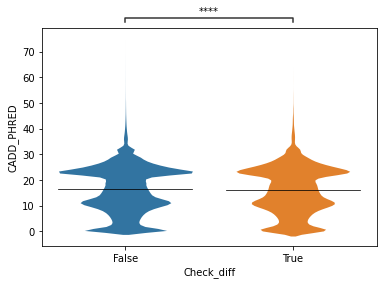

In [63]:
import seaborn as sns
from statannot import add_stat_annotation
import matplotlib.pyplot as plt
score_melt = exotic_variants.copy()
score_melt['Check_diff'] = score_melt['Check_diff'].astype(str)
hline = [
    [0.05,0.45],
    [0.55,0.95],
]

i = 0
for j, bin in enumerate(score_melt.Check_diff.unique()):

    m = score_melt.loc[(score_melt['Check_diff'] == bin), 'CADD_PHRED'].median()
    print(m)
    plt.axhline(xmin=hline[i][0], xmax=hline[i][1], y=m, color='black', lw=0.75)
    i+=1
b = sns.violinplot(data=score_melt, x='Check_diff', y='CADD_PHRED', linewidth=0)
add_stat_annotation(b, data=score_melt, x='Check_diff', y='CADD_PHRED', order= ['False', 'True'],
                            box_pairs=[('False', 'True')],
                            test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

0.13678187697788682
0.1400612094630563
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.755e-09 U_stat=8.955e+09


(<AxesSubplot:xlabel='Check_diff', ylabel='MISTIC'>,
 [<statannot.StatResult.StatResult at 0x7fa040f33a58>])

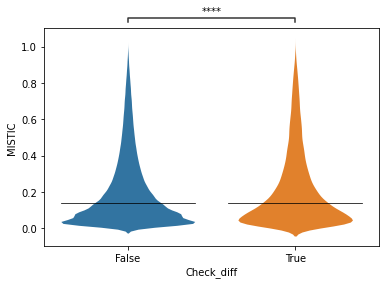

In [64]:
import seaborn as sns
from statannot import add_stat_annotation
import matplotlib.pyplot as plt
score_melt = exotic_variants.copy()
score_melt['Check_diff'] = score_melt['Check_diff'].astype(str)
hline = [
    [0.05,0.45],
    [0.55,0.95],
]

i = 0
for j, bin in enumerate(score_melt.Check_diff.unique()):

    m = score_melt.loc[(score_melt['Check_diff'] == bin), 'MISTIC'].median()
    print(m)
    plt.axhline(xmin=hline[i][0], xmax=hline[i][1], y=m, color='black', lw=0.75)
    i+=1
b = sns.violinplot(data=score_melt, x='Check_diff', y='MISTIC', linewidth=0)
add_stat_annotation(b, data=score_melt, x='Check_diff', y='MISTIC', order= ['False', 'True'],
                            box_pairs=[('False', 'True')],
                            test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

In [75]:
len(set(exotic.loc[exotic['EXOTIC_up'] > 0.6, 'symbol'].unique().tolist()).union(set(exotic.loc[exotic['EXOTIC_down'] < -0.6, 'symbol'].unique().tolist())))

1547

In [76]:
exotic.loc[exotic['EXOTIC_up'] > 0.6, 'symbol'].nunique()

869

In [77]:
exotic.loc[exotic['EXOTIC_down'] < -0.6, 'symbol'].nunique()

938

In [79]:
exotic.loc[exotic['EXOTIC_up'] > 0.6, 'MAP'].nunique()

2149

In [78]:
exotic.loc[exotic['EXOTIC_down'] < -0.6, 'MAP'].nunique()

2544